# Basic MLP DeepONet (style)

This is a quick pass at a DeepONet - not physics informed yet.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

In [3]:
N_SAMPLES = 32
EPOCHS = 1000
LR = 1e-4

## Damped harmonic oscillator

This should be something nice and simple I can train on.

In [4]:
def f(t, ζ, ω0):
    return 1 - np.exp(-t * ζ * ω0) * np.cos(ω0 * np.sqrt(1 - ζ**2) * t + np.arccos(ζ)) / np.sin(np.arccos(ζ))


def get_rand_ζ():
    return np.random.rand() * 0.2 + 0.3


def get_rand_ω0():
    return np.random.rand() * 10 * np.pi * 0.2 + 10

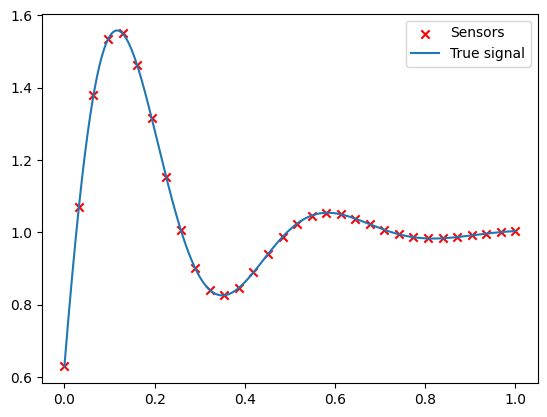

In [5]:
# ζ = 0.15
# ω0 = 10 * np.pi

ζ = get_rand_ζ()
ω0 = get_rand_ω0()

x = np.linspace(0, 1, 1000)
y = f(x, ζ, ω0)

x_sample = np.linspace(0, 1, 32)
y_sample = f(x_sample, ζ, ω0)

fig, ax = plt.subplots()

ax.scatter(x_sample, y_sample, color="r", marker="x", label="Sensors")
ax.plot(x, y, label="True signal")
_ = ax.legend()

## MLP

Start with this because it'll be easier to make sure I have the underlying mechanics in place.

I'll follow the rough idea behind the DeepONet (at least how it exists in my head) because it's quite straightforward.

### Data

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


class ONetData(Dataset):
    def __init__(self, N=1000, n_samples=N_SAMPLES, test=False):
        self.N = N
        self.n_samples = n_samples
        self.x_sensor = np.linspace(0, 1, self.n_samples)
        self.test = test

    def __len__(self):
        return self.N

    def __getitem__(self, _):
        ζ = get_rand_ζ()
        ω0 = get_rand_ω0()
        ux = f(self.x_sensor, ζ, ω0)
        y = np.random.rand()
        uy = f(y, ζ, ω0)
        if not self.test:
            return (
                torch.tensor(ux, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32)[..., None],
                torch.tensor(uy, dtype=torch.float32),
            )
        else:
            return (
                torch.tensor(ux, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32)[..., None],
                torch.tensor(uy, dtype=torch.float32),
                ζ,
                ω0,
            )

In [7]:
train_dset = ONetData(N=1000)
valid_dset = ONetData(N=1000)
test_dset = ONetData(N=1000, test=True)

train_dl = DataLoader(train_dset, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=64, shuffle=False)
test_dl = DataLoader(test_dset, batch_size=64, shuffle=False)

In [8]:
uxb, yb, uyb = next(iter(train_dl))
uxb.shape, yb.shape, uyb.shape

(torch.Size([64, 32]), torch.Size([64, 1]), torch.Size([64]))

### Model

In [9]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bn=False, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation
        if bn:
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        x = self.linear(x)
        if self.activation:
            x = self.activation(x)
        return x


class ONet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.context_mlp = nn.Sequential(
            LinearLayer(N_SAMPLES, 512, nn.Tanh()),
            LinearLayer(512, 512, nn.Tanh()),
            LinearLayer(512, 512, nn.Tanh()),
            LinearLayer(512, 512, nn.Tanh()),
            LinearLayer(512, 64, nn.Tanh()),
        )
        self.query_mlp = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
        )
        # self.output_mlp = nn.Sequential(
        #     LinearLayer(64, 1024, nn.Tanh),
        #     LinearLayer(1024, 1024, nn.Tanh),
        #     LinearLayer(1024, 1024, nn.Tanh),
        #     nn.Linear(1024, 1),
        # )

    def forward(self, ux, y):
        context = self.context_mlp(ux)
        query = self.query_mlp(y)
        # x = context + query
        # x = self.output_mlp(x)
        return torch.einsum("ij,ij->i", context, query)

In [10]:
model = ONet()

In [11]:
with torch.no_grad():
    uy_pred = model(uxb, yb)

uy_pred.shape, uyb.shape

(torch.Size([64]), torch.Size([64]))

In [12]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 842048


## Training

In [12]:
from torch.optim.lr_scheduler import OneCycleLR

In [13]:
model = ONet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = OneCycleLR(optimizer, max_lr=LR, total_steps=EPOCHS * len(train_dl))
step = -1
ldf = pd.DataFrame(columns=["train_loss", "valid_loss"])
for epoch in range(EPOCHS):
    model.train()
    for ux, y, uy in train_dl:
        step += 1
        row = {}
        optimizer.zero_grad()
        uy_pred = model(ux, y)
        loss = criterion(uy_pred, uy)
        loss.backward()
        optimizer.step()
        scheduler.step()
        row["train_loss"] = loss.item()
        ldf.loc[step] = row

    model.eval()
    with torch.no_grad():
        losses = []
        for ux, y, uy in valid_dl:
            uy_pred = model(ux, y)
            loss = criterion(uy_pred, uy)
            losses.append(loss.item())
        valid_loss = np.mean(losses)
        ldf.loc[step, "valid_loss"] = valid_loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: {valid_loss}")

Epoch 0: 0.04695986467413604
Epoch 10: 0.024672010447829962
Epoch 20: 0.027603812282904983
Epoch 30: 0.023476068978197873
Epoch 40: 0.02543006173800677
Epoch 50: 0.02636741811875254
Epoch 60: 0.021235806168988347
Epoch 70: 0.021941490471363068
Epoch 80: 0.018319020862691104
Epoch 90: 0.01676081633195281
Epoch 100: 0.012609938479727134
Epoch 110: 0.012223111785715446
Epoch 120: 0.009825224144151434
Epoch 130: 0.019001046137418598
Epoch 140: 0.00748773681698367
Epoch 150: 0.009066893078852445
Epoch 160: 0.0073187990637961775
Epoch 170: 0.008478596981149167
Epoch 180: 0.006831128237536177
Epoch 190: 0.0053542083041975275
Epoch 200: 0.0049131428968394175
Epoch 210: 0.014603252406232059
Epoch 220: 0.01650564937153831
Epoch 230: 0.01840658119181171
Epoch 240: 0.00594855917734094
Epoch 250: 0.004982057958841324
Epoch 260: 0.00511172111146152
Epoch 270: 0.004241269176418427
Epoch 280: 0.005671971041010693
Epoch 290: 0.008354635036084801
Epoch 300: 0.00391684657370206
Epoch 310: 0.0059166852879

## Results

In [87]:
def plot_loss(ldf):
    fig, ax = plt.subplots()
    ax.plot(ldf["train_loss"], label="Train loss", lw=0.1)
    ax.plot(ldf["valid_loss"].interpolate(), label="Valid loss", lw=0.8)
    ax.legend()
    ax.set_yscale("log")

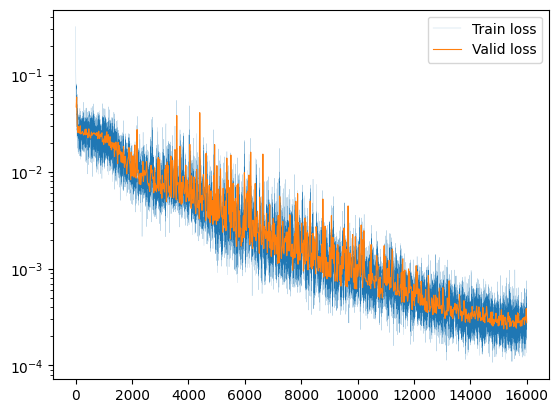

In [88]:
plot_loss(ldf)

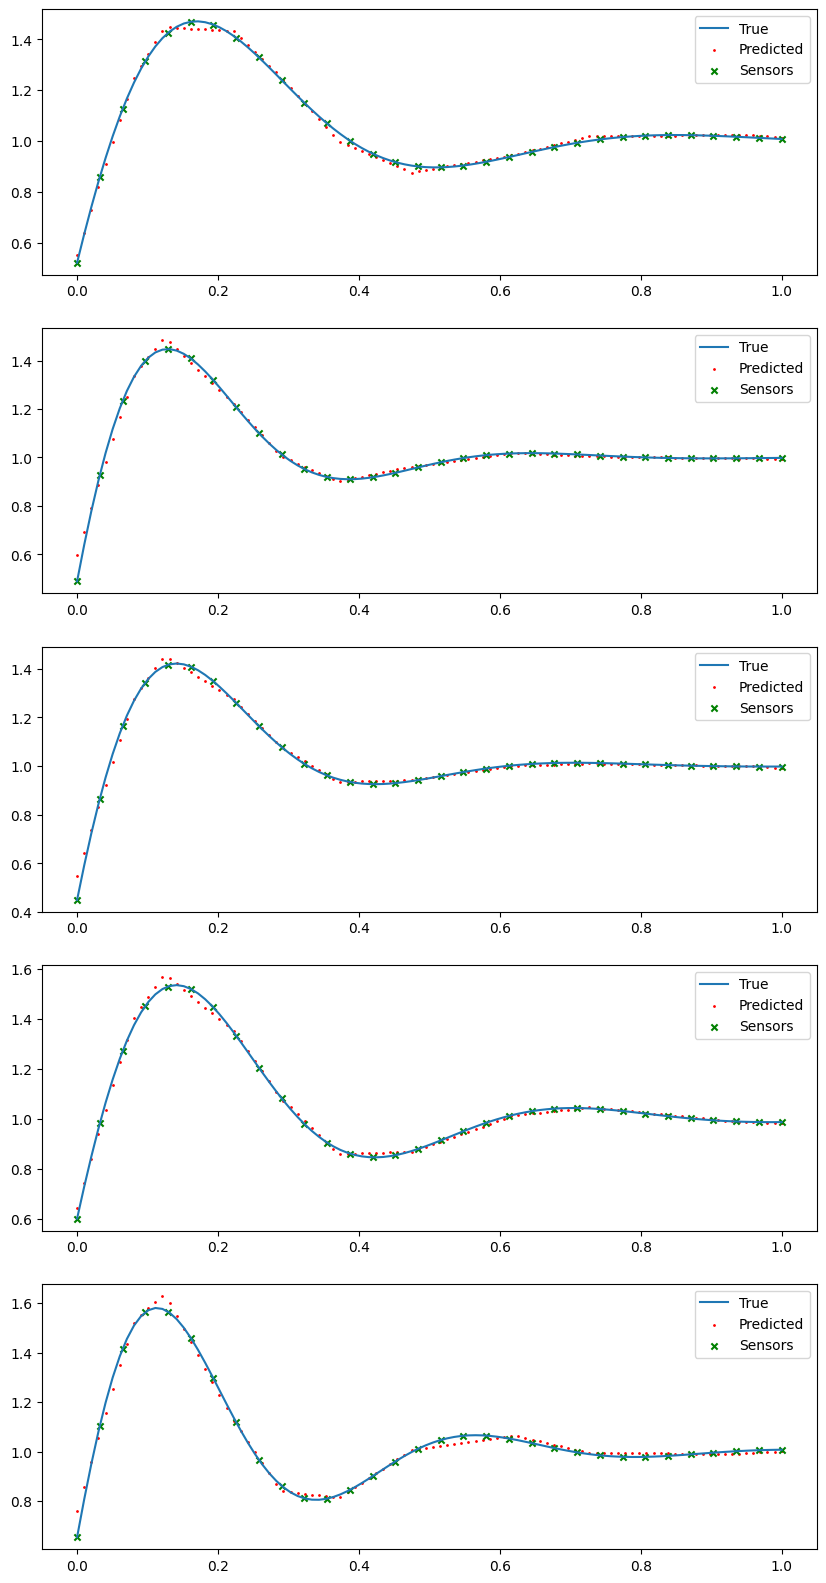

In [93]:
uxs = []
uy_preds = []
uy_trues = []
for i in range(5):
    ux, _, _, ζ, ω0 = test_dset[0]

    yb = np.linspace(0, 1, 100)[..., None]
    uyb = f(yb, ζ, ω0)

    uxb = ux[None].repeat(100, 1)

    yb = torch.tensor(yb, dtype=torch.float32)
    uyb = torch.tensor(uyb, dtype=torch.float32)

    with torch.inference_mode():
        uy_pred = model(uxb, yb)

    uxs.append(ux)
    uy_preds.append(uy_pred)
    uy_trues.append(uyb)

fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for i, (ux, uy_pred, uy_true) in enumerate(zip(uxs, uy_preds, uy_trues)):
    ax = axes[i]
    ax.plot(yb.flatten(), uy_true, label="True")
    ax.scatter(yb.flatten(), uy_pred, label="Predicted", color="r", s=1)
    ax.scatter(test_dset.x_sensor, ux, label="Sensors", color="green", s=20, marker="x")
    ax.legend()

Look at the variance in the predictions because I'm not sure how much it's being conditioned by the different function vs simply learning a static solution:

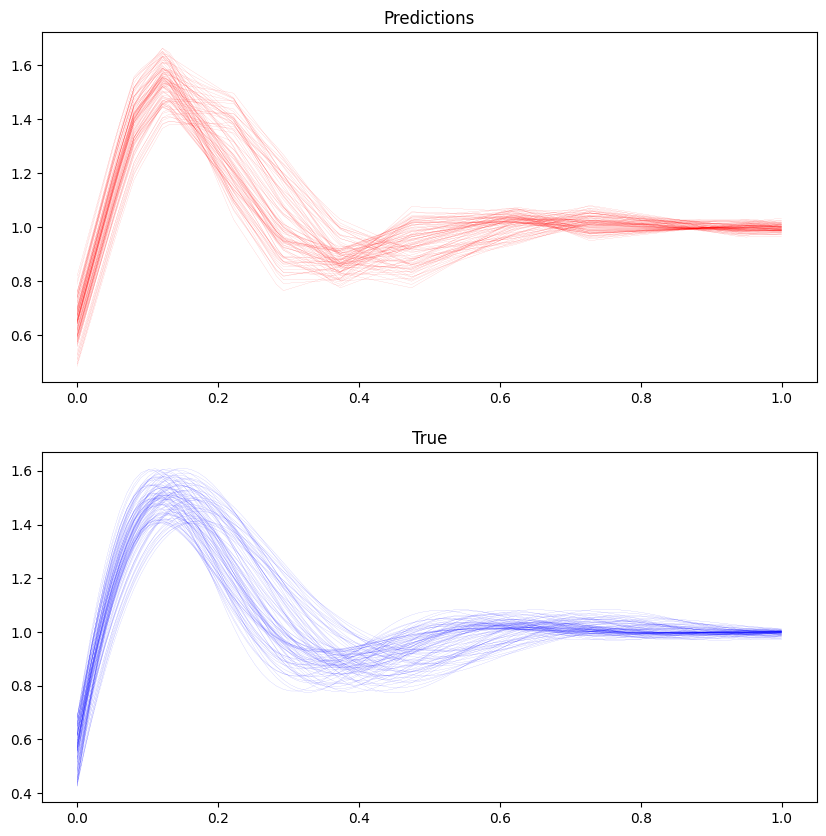

In [17]:
uy_preds = []
uybs = []
for i in range(100):
    ux, _, _, ζ, ω0 = test_dset[0]

    yb = np.linspace(0, 1, 100)[..., None]
    uyb = f(yb, ζ, ω0)

    uxb = ux[None].repeat(100, 1)

    yb = torch.tensor(yb, dtype=torch.float32)
    uyb = torch.tensor(uyb, dtype=torch.float32)

    with torch.inference_mode():
        uy_pred = model(uxb, yb)

    uy_preds.append(uy_pred)
    uybs.append(uyb)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for uy_pred in uy_preds:
    axes[0].plot(yb.flatten(), uy_pred, color="r", lw=0.05)
    axes[0].set_title("Predictions")

for uyb in uybs:
    axes[1].set_title("True")
    axes[1].plot(yb.flatten(), uyb, color="b", lw=0.05)